In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

### Load Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip "drive/My Drive/Colab Notebooks/dataset/face_mask_detection.zip"

Streaming output truncated to the last 5000 lines.
  inflating: face_mask_detection/train/Image_550.jpg  
  inflating: face_mask_detection/train/Image_5500.jpg  
  inflating: face_mask_detection/train/Image_5501.jpg  
  inflating: face_mask_detection/train/Image_5502.jpg  
  inflating: face_mask_detection/train/Image_5503.jpg  
  inflating: face_mask_detection/train/Image_5504.jpg  
  inflating: face_mask_detection/train/Image_5505.jpg  
  inflating: face_mask_detection/train/Image_5506.jpg  
  inflating: face_mask_detection/train/Image_5507.jpg  
  inflating: face_mask_detection/train/Image_5508.jpg  
  inflating: face_mask_detection/train/Image_5509.jpg  
  inflating: face_mask_detection/train/Image_551.jpg  
  inflating: face_mask_detection/train/Image_5510.jpg  
  inflating: face_mask_detection/train/Image_5511.jpg  
  inflating: face_mask_detection/train/Image_5512.jpg  
  inflating: face_mask_detection/train/Image_5513.jpg  
  inflating: face_mask_detection/train/Image_5514.jpg  

In [6]:
train_set = shuffle(pd.read_csv('face_mask_detection/Training_set_face_mask.csv'))
test_set = pd.read_csv('face_mask_detection/Testing_set_face_mask.csv')

In [7]:
train_set.head()

,filename,label
9988,Image_9989.jpg,with_mask
6014,Image_6015.jpg,with_mask
4798,Image_4799.jpg,without_mask
1248,Image_1249.jpg,without_mask
5741,Image_5742.jpg,with_mask


In [8]:
train_set.tail()

,filename,label
10524,Image_10525.jpg,with_mask
10492,Image_10493.jpg,with_mask
6811,Image_6812.jpg,with_mask
131,Image_132.jpg,without_mask
1486,Image_1487.jpg,without_mask


In [9]:
test_set.head()

,filename,label
0,Image_1.jpg,NaN
1,Image_2.jpg,NaN
2,Image_3.jpg,NaN
3,Image_4.jpg,NaN
4,Image_5.jpg,NaN


### Directory Preparation

Train / Validation Split

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_set = train_set.filename.values
y_set = train_set.label.values

In [12]:
X_train_set, X_valid_set, y_train_set, y_valid_set = train_test_split(X_set, y_set, test_size=0.2, stratify=y_set, random_state=1)

In [13]:
train_set_df = pd.DataFrame({
    'filename': X_train_set,
    'label': y_train_set
}, index=X_train_set)

In [14]:
valid_set_df = pd.DataFrame({
    'filename': X_valid_set,
    'label': y_valid_set
}, index=X_valid_set)

Rename files with giving their labels

In [15]:
import os, sys

In [16]:
dir = 'face_mask_detection/train/'
for _, filename in enumerate(os.listdir(dir)):
    try:
        new_filename = dir + train_set_df.loc[filename]['label'] + '_train_' + filename
        os.rename(dir+filename, new_filename)
    except:
        new_filename = dir + valid_set_df.loc[filename]['label'] + '_valid_' + filename
        os.rename(dir+filename, new_filename)

Structured Directory

In [17]:
!mkdir data

In [18]:
!mkdir data/train
!mkdir data/test

!mkdir data/train/without_mask
!mkdir data/train/with_mask
!mkdir data/test/without_mask
!mkdir data/test/with_mask

In [19]:
!mv face_mask_detection/train/with_mask_train*.jpg data/train/with_mask
!mv face_mask_detection/train/without_mask_train*.jpg data/train/without_mask
!mv face_mask_detection/train/with_mask_valid*.jpg data/test/with_mask
!mv face_mask_detection/train/without_mask_valid*.jpg data/test/without_mask

In [20]:
train_path = 'data/train'
valid_path = 'data/test'

In [21]:
IMG_SIZE = [200, 200]

In [22]:
from glob import glob

In [23]:
train_img_files = glob(train_path + '/*/*.jpg')
valid_img_files = glob(valid_path + '/*/*.jpg')

In [24]:
train_folders = glob(train_path + '/*')
train_folders

['data/train/without_mask', 'data/train/with_mask']

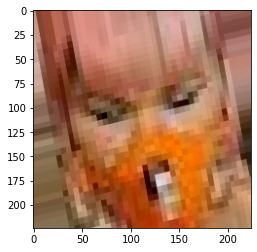

In [25]:
plt.imshow(image.load_img('data/train/with_mask/with_mask_train_Image_10000.jpg'))
plt.show()

### Model Train

#### Pre Trained Model

In [26]:
ptm = PretrainedModel(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SIZE + [3]
)

58892288/58889256 [==============================] - 1s 0us/step


In [27]:
ptm.trainable=False

#### Without Data Augmentation

In [28]:
dx = Flatten()(ptm.output)
dm = Model(inputs=ptm.input, outputs=dx)

In [29]:
dm.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)      

Data Generator without data augmentation

In [30]:
gend = ImageDataGenerator(preprocessing_function=preprocess_input)

In [31]:
batch_size = 128
train_gend = gend.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='binary'
)

valid_gend = gend.flow_from_directory(
    valid_path,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='binary'
)

Found 9011 images belonging to 2 classes.
Found 2253 images belonging to 2 classes.


In [32]:
# define shape of train and valid data after pre trained model
N_train = len(train_img_files)
N_valid = len(valid_img_files)

feat = dm.predict(np.random.random([1]+ IMG_SIZE+ [3]))
D = feat.shape[1]

Xd_train = np.zeros((N_train, D))
yd_train = np.zeros(N_train)
Xd_valid = np.zeros((N_valid, D))
yd_valid = np.zeros(N_valid)

In [33]:
i = 0
for x, y in train_gend:
    # get features
    features = dm.predict(x)

    # size of batch
    sz = len(y)

    Xd_train[i:i+sz] = features
    yd_train[i:i+sz] = y

    i += sz
    print(i)

    if i >= N_train:
        print('stop now') # after train length achieved stop populate data or it will be looping forever
        break
print(i)

128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3072
3200
3328
3456
3584
3712
3840
3968
4096
4224
4352
4480
4608
4736
4864
4992
5120
5248
5376
5504
5632
5760
5888
6016
6144
6272
6400
6528
6656
6784
6912
7040
7168
7296
7424
7552
7680
7808
7936
8064
8192
8320
8448
8576
8704
8832
8960
9011
stop now
9011


In [54]:
Xd_train.shape

(9011, 18432)

In [34]:
i = 0
for x, y in valid_gend:
    # get features
    features = dm.predict(x)

    # size of batch
    sz = len(y)

    Xd_valid[i:i+sz] = features
    yd_valid[i:i+sz] = y

    i += sz
    print(i)

    if i >= N_valid:
        print('stop now') # after valid length achieved stop populate data or it will be looping forever
        break
print(i)

128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2253
stop now
2253


In [55]:
Xd_valid.shape

(2253, 18432)

Normalize Data

In [35]:
from sklearn.preprocessing import StandardScaler

In [36]:
scaler = StandardScaler()
Xd_train = scaler.fit_transform(Xd_train)
Xd_valid = scaler.transform(Xd_valid)

Train Data

Simple Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
lm = LogisticRegression()
lm.fit(Xd_train, yd_train)
print(f'Logistic Regression Train Score: {lm.score(Xd_train, yd_train)}')
print(f'Logistic Regression Validation Score: {lm.score(Xd_valid, yd_valid)}')

Logistic Regression Train Score: 1.0
Logistic Regression Validation Score: 0.9942299156679982


NN

In [45]:
i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)

In [46]:
model = Model(i, x)
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 18432)]           0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 18433     
Total params: 18,433
Trainable params: 18,433
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [48]:
r = model.fit(Xd_train, yd_train, epochs=12, batch_size=128, validation_data=(Xd_valid, yd_valid))

Epoch 1/12
71/71 [==============================] - 1s 14ms/step - loss: 0.0847 - accuracy: 0.9699 - val_loss: 0.0261 - val_accuracy: 0.9902
Epoch 2/12
71/71 [==============================] - 1s 9ms/step - loss: 0.0050 - accuracy: 0.9986 - val_loss: 0.0256 - val_accuracy: 0.9902
Epoch 3/12
71/71 [==============================] - 1s 9ms/step - loss: 0.0069 - accuracy: 0.9991 - val_loss: 0.0239 - val_accuracy: 0.9907
Epoch 4/12
71/71 [==============================] - 1s 8ms/step - loss: 0.0054 - accuracy: 0.9994 - val_loss: 0.0230 - val_accuracy: 0.9920
Epoch 5/12
71/71 [==============================] - 1s 8ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 0.0234 - val_accuracy: 0.9916
Epoch 6/12
71/71 [==============================] - 1s 9ms/step - loss: 0.0041 - accuracy: 0.9998 - val_loss: 0.0234 - val_accuracy: 0.9916
Epoch 7/12
71/71 [==============================] - 1s 9ms/step - loss: 0.0036 - accuracy: 0.9997 - val_loss: 0.0215 - val_accuracy: 0.9920
Epoch 8/12
71/71 [=

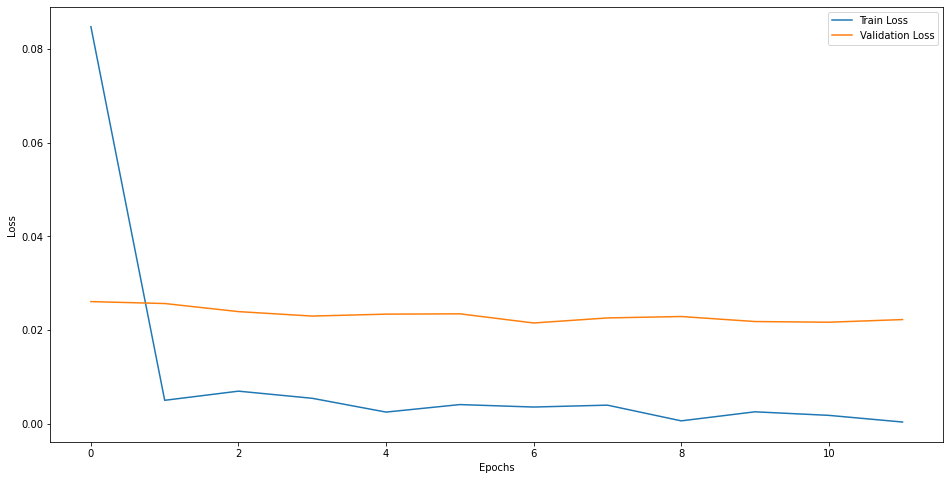

In [49]:
plt.figure(figsize=(16, 8))
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

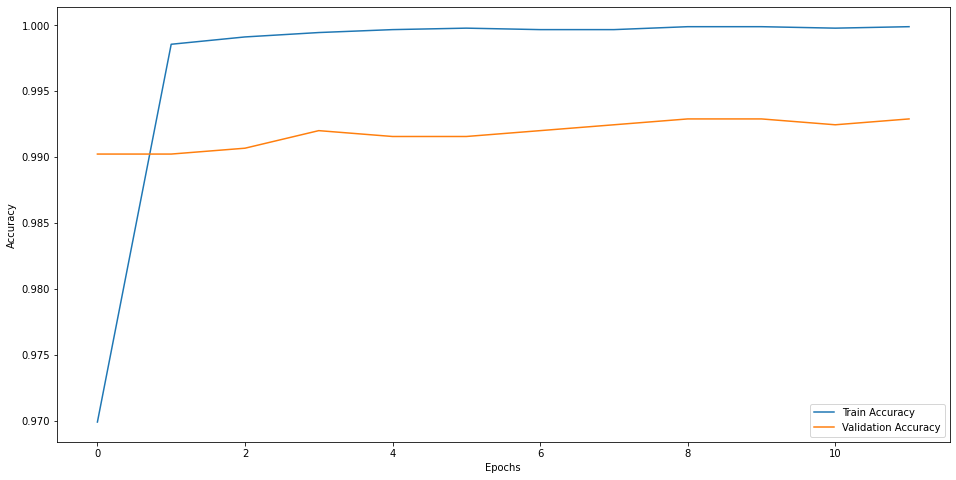

In [50]:
plt.figure(figsize=(16, 8))
plt.plot(r.history['accuracy'], label='Train Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Predictions

In [60]:
test_set_df = pd.DataFrame({
    'filename': test_set['filename'].values,
    'label': test_set['label'].values
}, index=test_set['filename'].values)

In [74]:
y_preds = []
test_path = 'face_mask_detection/test/'
for f in test_set_df['filename']:
    filename = test_path + f
    img = image.load_img(filename, target_size=IMG_SIZE)
    img = image.img_to_array(img)
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    img = preprocess_input(img)

    feat_test = dm.predict(img)
    feat_test = scaler.transform(feat_test)
    y_pred = np.round(model.predict(feat_test)[0][0])
    y_preds.append(y_pred)

Result -> 1 without mask; 0 with mask

In [78]:
test_set_df['label'] = y_preds
test_set_df['label'] = test_set_df['label'].map({1.0: 'without_mask', 0.0: 'with_mask'})

In [79]:
test_set_df.head()

,filename,label
Image_1.jpg,Image_1.jpg,without_mask
Image_2.jpg,Image_2.jpg,with_mask
Image_3.jpg,Image_3.jpg,without_mask
Image_4.jpg,Image_4.jpg,with_mask
Image_5.jpg,Image_5.jpg,with_mask


Sample Plot

without_mask


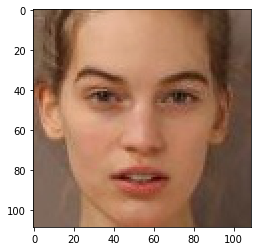

In [85]:
test_img = 'Image_3.jpg'
print(test_set_df.loc[test_img]['label'])
plt.imshow(image.load_img(test_path + test_img))
plt.show()

In [90]:
result_df = pd.DataFrame({
    'prediction': test_set_df['label'].values
})
result_df.to_csv('fmd_result.csv', index=False)